In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Preparation

In [147]:
df = pd.read_excel('Online Retail.xlsx')
df = df.replace(to_replace="Israel", value="Palestine")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [149]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [150]:
id = 1
for i in range(len(df)):
    if np.isnan(df.iloc[i, 6]):
        df.iloc[i, 6] = id
        if df.iloc[i, 0] != df.iloc[i+1, 0]:
            id += 1

In [151]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     541909
Country        541909
dtype: int64

# Feature Engineering

In [152]:
def customer_shopping_report(df, id):
    customer_df = df[(df['CustomerID']==id) & (df['Quantity']>0)]
    
    if customer_df.empty:
        return False
    
    total_spend = 0
    for index, row in customer_df.iterrows():
        total_spend += row['UnitPrice'] * row['Quantity']
        
    freq_order = len(customer_df['InvoiceNo'].unique())
    avg_basket_size = sum(customer_df['Quantity']) / freq_order
    country = customer_df['Country'].iloc[0]
    
    return [total_spend, avg_basket_size, freq_order, country]

In [153]:
seg_df = pd.DataFrame(columns=['TotalSpend', 'AvgBasketSize', 'FreqOrder', 'Country'])

customer_id_unique = df['CustomerID'].unique()
for id in customer_id_unique:
    if customer_shopping_report(df, id) != False:
        seg_df.loc[len(seg_df)] = customer_shopping_report(df, id)
    
seg_df.head()

,TotalSpend,AvgBasketSize,FreqOrder,Country
0,5391.21,50.970588,34,United Kingdom
1,3237.54,139.100000,10,United Kingdom
2,7281.38,337.333333,15,France
3,948.25,87.800000,5,United Kingdom
4,876.00,26.666667,3,United Kingdom


In [154]:
seg_df.describe()

,TotalSpend,AvgBasketSize,FreqOrder
count,6531.000000,6531.000000,6531.000000
mean,1629.851542,243.673408,3.173787
std,7467.716324,1135.537221,6.467705
min,-11062.060000,1.000000,1.000000
25%,130.245000,49.000000,1.000000
50%,501.120000,131.000000,1.000000
75%,1456.875000,269.305556,3.000000
max,280206.020000,74215.000000,210.000000


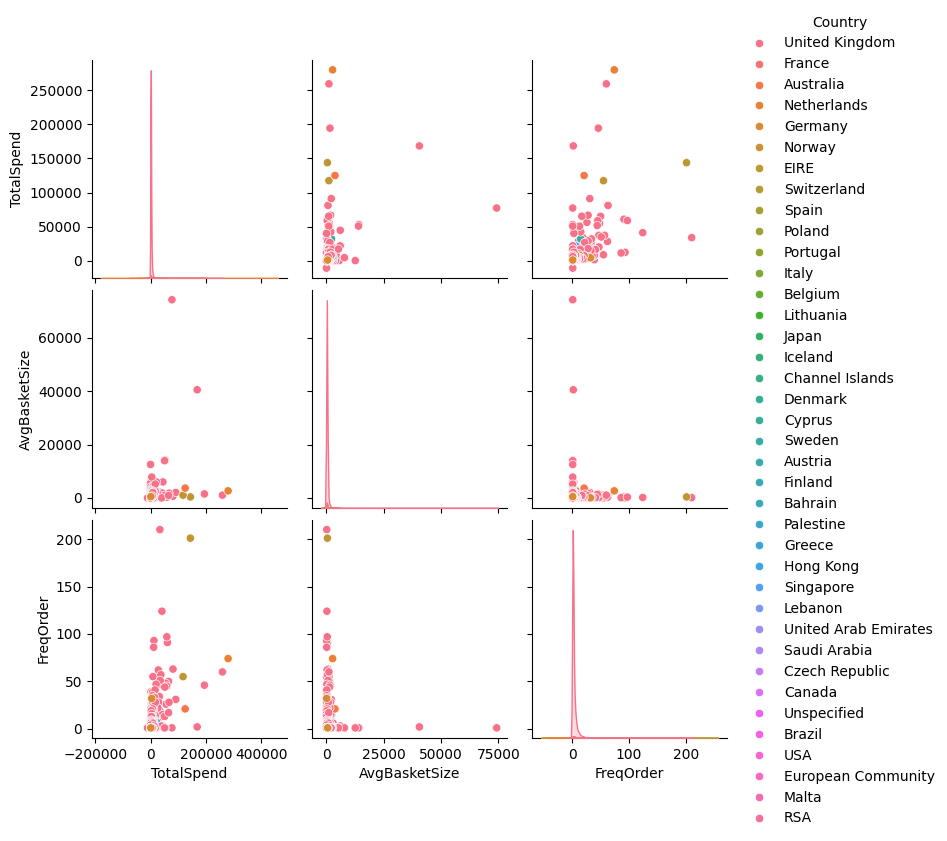

In [155]:
sns.pairplot(seg_df, hue='Country')

<AxesSubplot:ylabel='FreqOrder'>

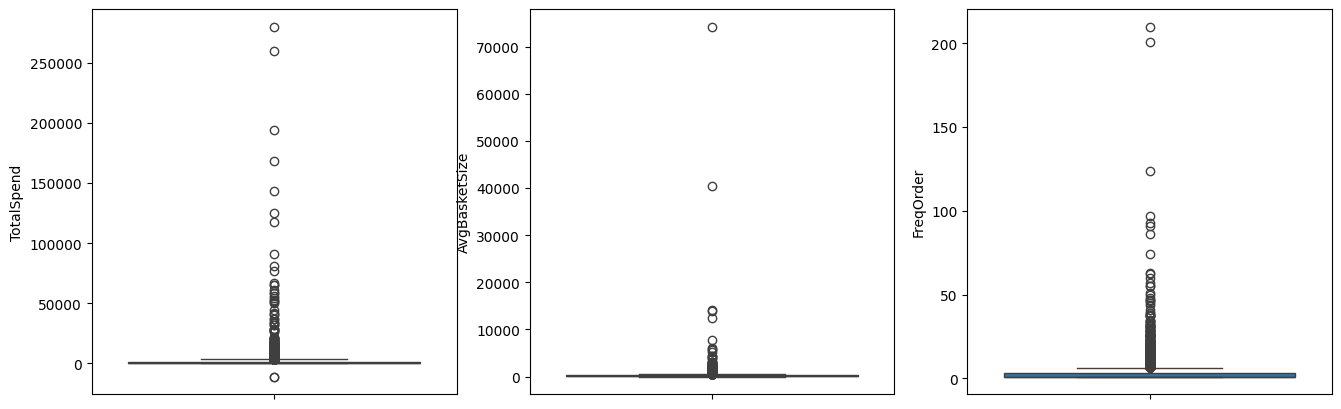

In [166]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(seg_df['TotalSpend'], ax=axes[0])
sns.boxplot(seg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(seg_df['FreqOrder'], ax=axes[2])

In [157]:
def remove_outliers(df, col_name):
    heigth = df[col_name].mean() + 3*df[col_name].std()
    lowest = df[col_name].mean() - 3*df[col_name].std()
    
    return df[(df[col_name]<heigth) & (df[col_name]>lowest)]

In [167]:
newseg_df = remove_outliers(seg_df, 'TotalSpend')
newseg_df = remove_outliers(seg_df, 'AvgBasketSize')
newseg_df = remove_outliers(seg_df, 'FreqOrder')

<AxesSubplot:ylabel='FreqOrder'>

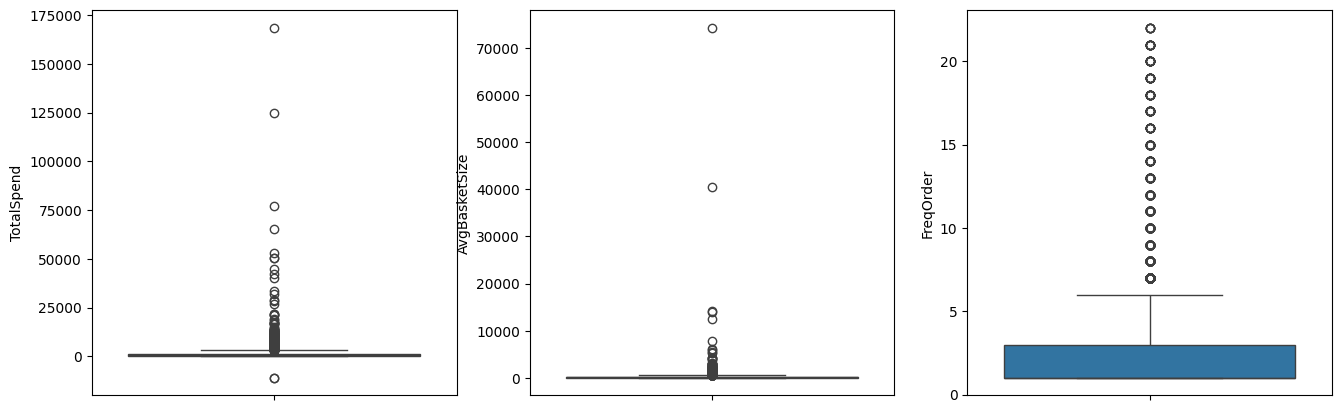

In [169]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(newseg_df['TotalSpend'], ax=axes[0])
sns.boxplot(newseg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(newseg_df['FreqOrder'], ax=axes[2])

# Dimensionality Reduction with PCA

In [175]:
x = newseg_df.drop('Country', axis=1)
x_scl = StandardScaler().fit_transform(x)

In [176]:
dim_red = PCA()
x_pca = dim_red.fit_transform(x_scl)
dim_red.explained_variance_ratio_

array([0.57022849, 0.33276717, 0.09700433])

In [177]:
dim_red.get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [178]:
df_pca = pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())
df_pca

,pca0,pca1,pca2
0,1.180409,2.010291,-0.433805
1,2.632634,3.260469,-0.367853
2,0.134072,0.691671,-0.248228
3,-0.147916,0.182723,0.005513
4,2.039562,3.352375,-0.753887
...,...,...,...
6447,1.600960,-1.151646,0.414105
6448,1.936348,-1.273496,0.472733
6449,0.384494,-0.645089,0.349090
6450,0.883871,-0.681898,0.766865


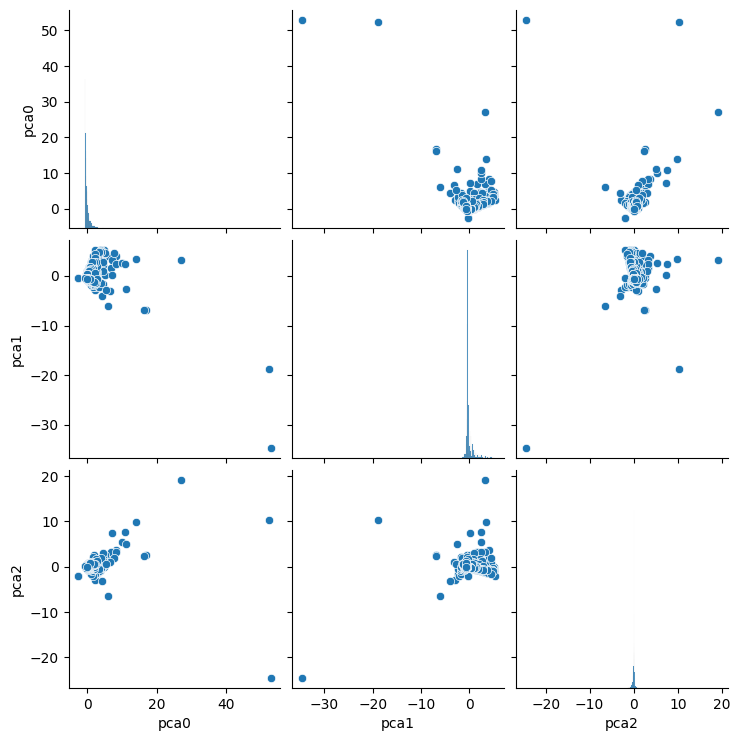

In [179]:
sns.pairplot(df_pca)

<AxesSubplot:ylabel='pca2'>

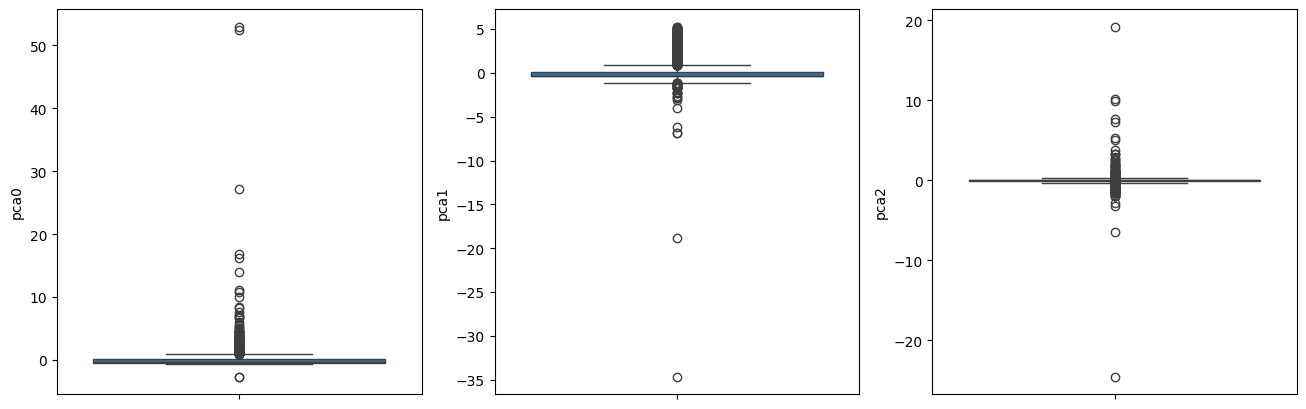

In [180]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
sns.boxplot(df_pca['pca2'], ax=axes[2])

In [181]:
df_pca = remove_outliers(df_pca, 'pca0')
df_pca = remove_outliers(df_pca, 'pca1')
df_pca = remove_outliers(df_pca, 'pca2')

<AxesSubplot:ylabel='pca2'>

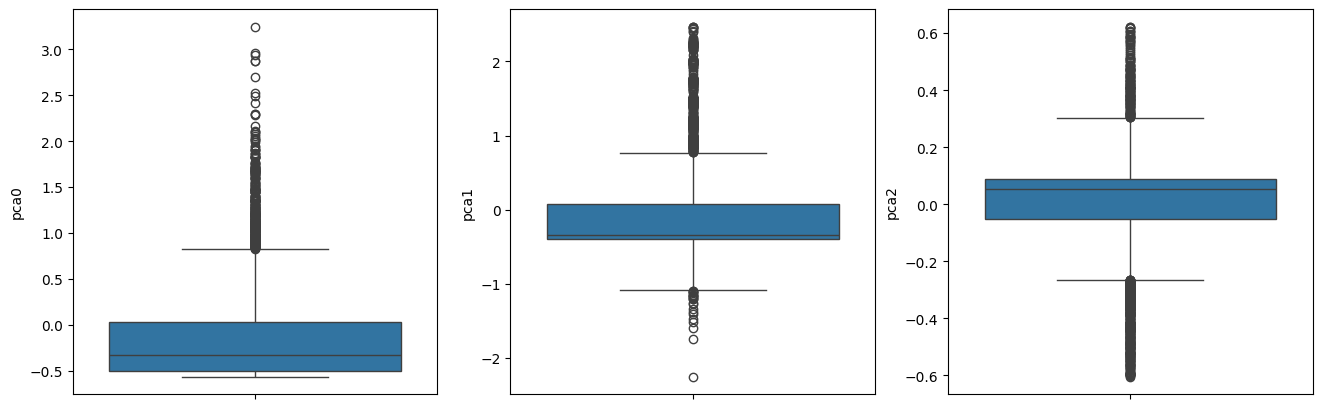

In [182]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
sns.boxplot(df_pca['pca2'], ax=axes[2])

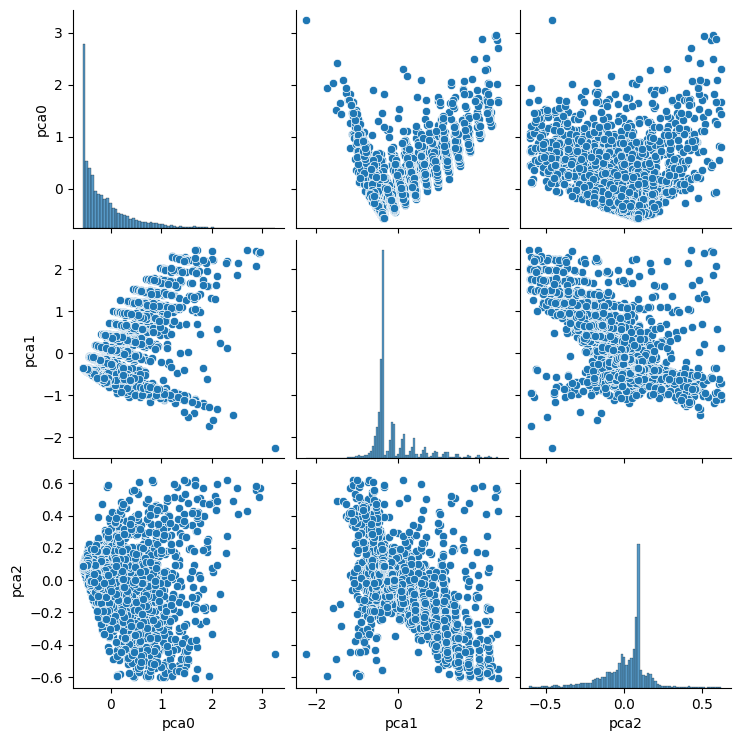

In [183]:
sns.pairplot(df_pca)

# Determining Optimal Number of Clusters